# Cryosat - model comparison in Iceland

In [1]:
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL, cfg
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Vatnajökull rgi_ids

In [2]:
dtcf_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/iceland/'
fp_rgi_ids = utils.file_downloader(dtcf_url + 'vatnajokull_rgi_ids.yml')
with open(fp_rgi_ids, 'r') as yaml_file:
    rgi_ids = yaml.safe_load(yaml_file)['rgi_ids']

## get preprocessed data of OGGM

In [3]:
cfg.initialize(logging_level='ERROR')
working_dir = utils.get_temp_dir('working_dir')
cfg.PATHS['working_dir'] = working_dir

gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)

2025-01-31 11:15:16: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-01-31 11:15:16: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-01-31 11:15:16: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-01-31 11:15:18: oggm.workflow: init_glacier_directories from prepro level 4 on 118 glaciers.
2025-01-31 11:15:18: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 118 glaciers
2025-01-31 11:15:18: oggm.workflow: WARNING: you are trying to run an entity task on 118 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


## Elevation change comparison

### Redo run for getting monthly output and load data

In [4]:
cfg.PARAMS['continue_on_error'] = True
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             init_model_filesuffix='_spinup_historical',
                             init_model_yr=1979,
                             store_monthly_step=True,
                             ys=1979, ye=2020,
                             mb_elev_feedback='monthly',
                             output_filesuffix='_spinup_historical_monthly')

ds_monthly =  utils.compile_run_output(gdirs, input_filesuffix='_spinup_historical_monthly')

2025-01-31 11:15:38: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-01-31 11:15:38: oggm.workflow: Execute entity tasks [run_from_climate_data] on 118 glaciers
2025-01-31 11:15:38: oggm.workflow: WARNING: you are trying to run an entity task on 118 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2025-01-31 11:15:42: oggm.core.flowline: AttributeError occurred during task run_from_climate_data_spinup_historical_monthly on RGI60-06.00387: 'Dataset' object has no attribute 'time'
2025-01-31 11:16:14: oggm.utils: Applying global task compile_run_output on 118 glaciers
2025-01-31 11:16:14: oggm.utils: Applying compile_run_output on 118 gdirs.


### calculate modelled elevation change

In [5]:
volume_total = ds_monthly.sum(dim='rgi_id').volume

# it is a bit unclear which basline was used by the observation
# from the meta_data: "average of the first 5 months (all data pre-2011)"
baseline_volume = np.mean(volume_total.sel(time=slice(2011, 2011.5)))

# divide by RGI area, which is the same area as used by the creation of the observation
rgi_area = 0
for gdir in gdirs:
    rgi_area += gdir.rgi_area_m2

# finally the calculation of the modelled elevation change
model_elev = (volume_total - baseline_volume) / rgi_area

## Load observations of elevation change

In [6]:
obs_file = utils.file_downloader(dtcf_url + 'averaged_grid.csv')
df_obs_elev = pd.read_csv(obs_file, index_col=1)
df_obs_elev.index = pd.to_datetime(df_obs_elev.index)
df_obs_elev = df_obs_elev['changes_t0']  # only keep average which is used for comparision

## plot elevation change observed vs. modelled

Text(0.5, 1.0, 'Vatnajökull elevation change')

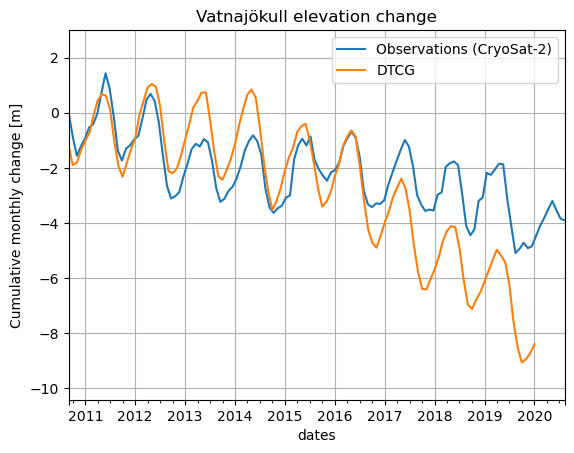

In [7]:
fig, ax = plt.subplots(1, 1)

df_obs_elev.plot(ax=ax, label='Observations (CryoSat-2)')

years, months = utils.floatyear_to_date(ds_monthly.time)
ax.plot(pd.to_datetime({'year': years, 'month': months, 'day': 1}),
        model_elev,
        label='DTCG')

ax.set_ylabel('Cumulative monthly change [m]')
ax.legend()
ax.grid('on')
ax.set_ylim([None, 3])
ax.set_title('Vatnajökull elevation change')

## WGMS comparison

### load WGMS data

In [8]:
fp_wgms = utils.file_downloader(dtcf_url + 'WGMS_MB-DTC-Glaciers.csv')
wgms_data = pd.read_csv(fp_wgms)

### help function to access WGMS data

In [9]:
# conversions between wgms ids and rgi ids
fp_wgms_ids_conversion = utils.file_downloader(dtcf_url + 'glacier_id_lut.csv')
df_wgms_ids = pd.read_csv(fp_wgms_ids_conversion)

def get_wgms_from_rgi(rgi_id):
    if rgi_id in df_wgms_ids['RGI60_ID'].values:
        return df_wgms_ids[df_wgms_ids['RGI60_ID'] == rgi_id]['WGMS_ID'].item()
    else:
        return None

def get_rgi_from_wgms(wgms_id):
    if wgms_id in df_wgms_ids['WGMS_ID'].values:
        return df_wgms_ids[df_wgms_ids['WGMS_ID'] == wgms_id]['RGI60_ID'].item()
    else:
        return None    

In [10]:
def get_wgms_mb_observation(rgi_id):
    '''
    Returns (mb_DataFrame, Glacier name)
    '''
    wgms_id = get_wgms_from_rgi(rgi_id)
    
    # only not None if this glacier is a WGMS glacier
    if wgms_id:
        # check if we have some data
        if wgms_id in wgms_data['glacier_id'].values:
            wgms_glacier_data = wgms_data[wgms_data['glacier_id'] == wgms_id]
            df_wgms_glacier_data = pd.DataFrame(
                {'annual_balance': wgms_glacier_data['annual_balance'].values},
                # ignoring hydro dates for now, as it is also what the model does
                index=pd.to_datetime(wgms_glacier_data['year'].values.astype(str)),
            )
            return df_wgms_glacier_data, wgms_glacier_data['glacier_id.short_name'].values[0]

## open modelled data

In [11]:
ds_annual = utils.compile_run_output(gdirs, input_filesuffix='_spinup_historical')

2025-01-31 11:16:29: oggm.utils: Applying global task compile_run_output on 118 glaciers
2025-01-31 11:16:29: oggm.utils: Applying compile_run_output on 118 gdirs.


### function for calculating modelled mb

In [12]:
def get_smb(ds, rgi_id):
    volume = ds.loc[{'rgi_id': rgi_id}].volume.values
    area = ds.loc[{'rgi_id': rgi_id}].area.values
    smb = (volume[1:] - volume[:-1]) / area[1:] * cfg.PARAMS['ice_density'] / 1000
    return smb

### Plot WGMS and modelled mb for all available glaciers

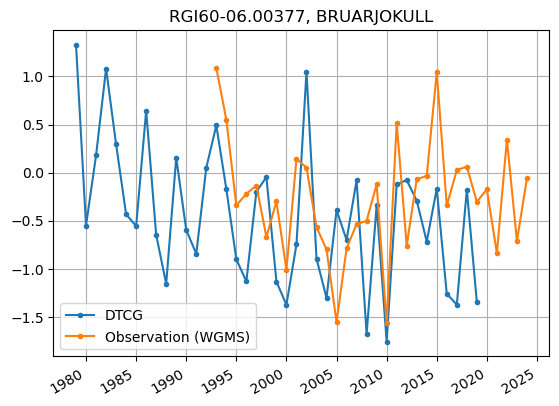

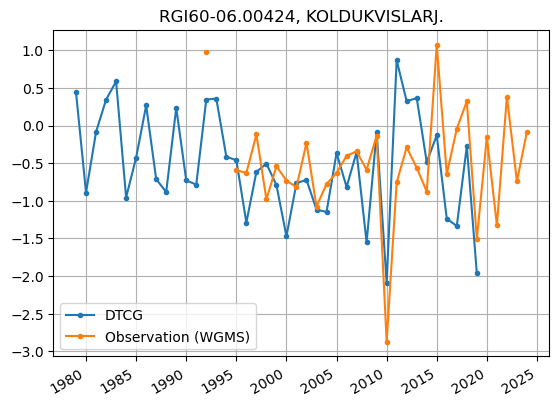

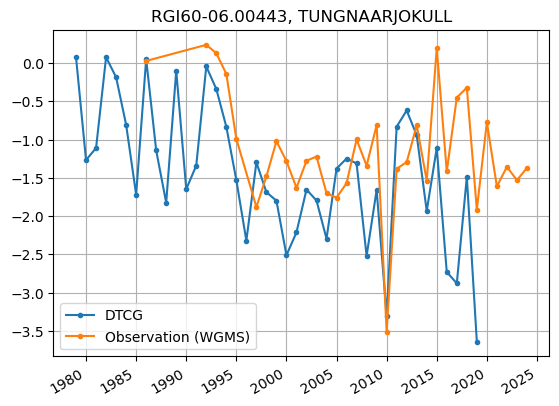

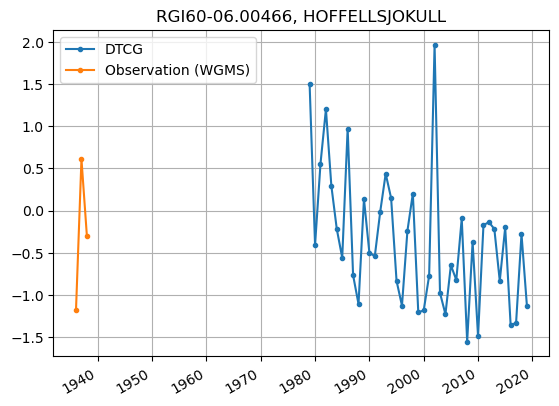

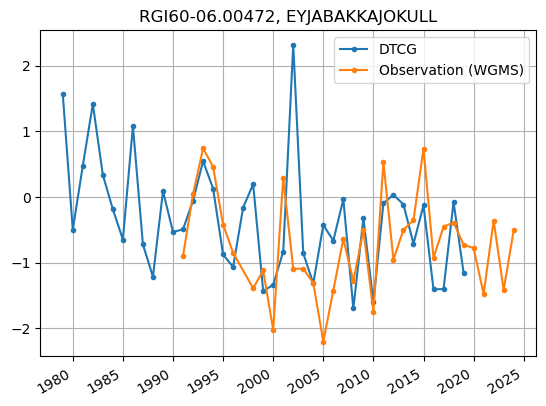

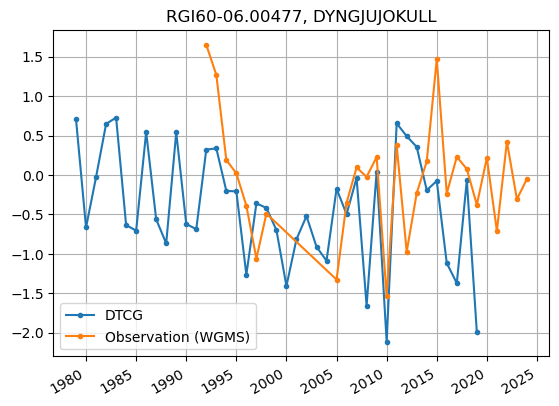

In [13]:
for gdir in gdirs:
    wgms_mb = get_wgms_mb_observation(gdir.rgi_id)

    if wgms_mb is not None:
        fig, ax = plt.subplots(1, 1)

        # add modelled smb
        ax.plot(pd.to_datetime({'year': ds_annual.time[:-1], 'month': 1, 'day': 1}),
                get_smb(ds_annual, gdir.rgi_id),
                '.-',
                label='DTCG',
               )
        
        # add observation
        wgms_mb[0]['annual_balance'].plot(ax=ax, marker='.',
                                          label='Observation (WGMS)')
        
        ax.set_title(f'{gdir.rgi_id}, {wgms_mb[1]}')
        ax.legend()
        ax.grid('on')
        plt.show()